# OpenJij SA Parameter Dependency Experiment with MINTO

This notebook is a simple experiment to see how the parameters of the Simulated Annealing (SA) algorithm in OpenJij affect the performance of the algorithm.  

The SA algorithm has temperature as a parameter, and OpenJij automatically sets this temperature based on the coefficients of QUBO or Ising models. Let's verify how effective these automatic parameter settings are by using grid search.

Even in grid search cases, using MINTO for logging allows us to easily convert the data to pandas.DataFrame for visualization. This helps us analyze the relationship between different parameter combinations and their impact on solution quality and execution time.

In [1]:
import openjij as oj
import numpy as np
import minto
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Create Random QUBO

In [2]:
def random_qubo(n, sparsity=0.5):
    q = np.random.uniform(-1, 1, (n, n))
    q = (q + q.T) / 2
    zero_num = int(n**2 * sparsity)
    zero_i = np.random.choice(n, zero_num, replace=True)
    zero_j = np.random.choice(n, zero_num, replace=True)
    q[zero_i, zero_j] = 0
    q[zero_j, zero_i] = 0
    qubo = {}
    for i in range(n-1):
        for j in range(i, n):
            qubo[(i, j)] = q[i, j]
            qubo[(j, i)] = q[j, i]
    return qubo


In [3]:
n = 200
q = random_qubo(n)

## 2. Run with default parameters

In OpenJij, you can check the automatically configured SA parameters through `.info['schedule']` in the return value of `.sample_qubo`. These parameters are stored under the key 'schedule' since the temperature settings in SA are referred to as the annealing schedule.

In [4]:
sampler = oj.SASampler()
response = sampler.sample_qubo(q)
schedule = response.info["schedule"]
schedule

{'beta_max': 23419.346516449466,
 'beta_min': 0.16080952839167884,
 'num_sweeps': 1000}

## 3. Grid search with MINTO

Let's see how the optimization results change by varying the inverse temperature parameters of SA. We'll include OpenJij's default parameters in our search range for comparison.

The important values from OpenJij's results are stored using `.log_parameter` method. The complete OpenJij response object is also saved using `.log_object` method with `.to_serializable`.

In [5]:
exp = minto.Experiment(auto_saving=False, verbose_logging=False)

# log_object accepts only serializable objects
# so we need to convert qubo to serializable object
qubo_edges = [[i, j] for i, j in q.keys()]
qubo_vales = [q[i, j] for i, j in qubo_edges]
exp.log_global_object("qubo", {"qubo_edges": qubo_edges, "qubo_vales": qubo_vales})

beta_min_list = [schedule["beta_min"], 0.1, 1.0, 2.0, 3.0, 4.0, 5.0]
beta_max_list = [10.0, 20, 30.0, 40.0, 50.0, 12404, schedule["beta_max"]]
num_reads = 300

exp.log_global_parameter("num_reads", num_reads)

for beta_min in beta_min_list:
    for beta_max in beta_max_list:
        run = exp.run()
        with run:
            sampler = oj.SASampler()
            response = exp.log_solver(sampler.sample_qubo)(q, num_reads=num_reads, beta_min=beta_min, beta_max=beta_max)
            beta_min = response.info["schedule"]["beta_min"]
            beta_max = response.info["schedule"]["beta_max"]
            run.log_parameter("beta_min", beta_min)
            run.log_parameter("beta_max", beta_max)
            run.log_object("response", response.to_serializable())
            energies = response.energies
            run.log_parameter("mean_energy", np.mean(energies))
            run.log_parameter("std_energy", np.std(energies))
            run.log_parameter("min_energy", np.min(energies))
            run.log_parameter("exec_time", response.info["execution_time"])

In [6]:
run_table = exp.get_run_table()
run_table

parameter                                                          \
        solver_name num_reads beta_min      beta_max mean_energy std_energy   
run_id                                                                        
0       sample_qubo       300  0.16081     10.000000 -400.824501   0.484598   
1       sample_qubo       300  0.16081     20.000000 -400.856420   0.430543   
2       sample_qubo       300  0.16081     30.000000 -400.879704   0.426166   
3       sample_qubo       300  0.16081     40.000000 -400.832098   0.587155   
4       sample_qubo       300  0.16081     50.000000 -400.822022   0.554464   
5       sample_qubo       300  0.16081  12404.000000 -400.751895   0.727066   
6       sample_qubo       300  0.16081  23419.346516 -400.866998   0.390925   
7       sample_qubo       300  0.10000     10.000000 -400.846235   0.430128   
8       sample_qubo       300  0.10000     20.000000 -400.871184   0.487043   
9       sample_qubo       300  0.10000     30.000000 -400.902827   0.408157   
10      sample_qubo       300  0.10000     40.000000 -400.846486   0.518750   
11      sample_qubo       300  0.10000     50.000000 -400.871300   0.414777   
12      sample_qubo       300  0.10000  12404.000000 -400.763619   0.681448   
13      sample_qubo       300  0.10000  23419.346516 -400.798245   0.626965   
14      sample_qubo       300  1.00000     10.000000 -400.876989   0.393766   
15      sample_qubo       300  1.00000     20.000000 -400.913995   0.284922   
16      sample_qubo       300  1.00000     30.000000 -400.917115   0.326967   
17      sample_qubo       300  1.00000     40.000000 -400.897331   0.327189   
18      sample_qubo       300  1.00000     50.000000 -400.873310   0.435403   
19      sample_qubo       300  1.00000  12404.000000 -400.782218   0.736565   
20      sample_qubo       300  1.00000  23419.346516 -400.752245   0.750855   
21      sample_qubo       300  2.00000     10.000000 -400.275671   1.410707   
22      sample_qubo       300  2.00000     20.000000 -400.273639   1.434920   
23      sample_qubo       300  2.00000     30.000000 -400.321825   1.388250   
24      sample_qubo       300  2.00000     40.000000 -400.343488   1.390948   
25      sample_qubo       300  2.00000     50.000000 -400.077238   1.566290   
26      sample_qubo       300  2.00000  12404.000000 -399.901651   1.722083   
27      sample_qubo       300  2.00000  23419.346516 -399.657682   1.894547   
28      sample_qubo       300  3.00000     10.000000 -399.902580   1.671486   
29      sample_qubo       300  3.00000     20.000000 -399.912649   1.695561   
30      sample_qubo       300  3.00000     30.000000 -399.732836   1.784211   
31      sample_qubo       300  3.00000     40.000000 -399.539447   1.908955   
32      sample_qubo       300  3.00000     50.000000 -399.949886   1.626373   
33      sample_qubo       300  3.00000  12404.000000 -399.170922   2.257485   
34      sample_qubo       300  3.00000  23419.346516 -399.142392   2.283888   
35      sample_qubo       300  4.00000     10.000000 -399.468546   2.045237   
36      sample_qubo       300  4.00000     20.000000 -399.663096   1.891882   
37      sample_qubo       300  4.00000     30.000000 -399.223775   2.156165   
38      sample_qubo       300  4.00000     40.000000 -399.244652   2.301861   
39      sample_qubo       300  4.00000     50.000000 -399.255288   2.244128   
40      sample_qubo       300  4.00000  12404.000000 -397.954240   2.918028   
41      sample_qubo       300  4.00000  23419.346516 -398.225302   2.876724   
42      sample_qubo       300  5.00000     10.000000 -399.310750   2.116636   
43      sample_qubo       300  5.00000     20.000000 -398.984841   2.656825   
44      sample_qubo       300  5.00000     30.000000 -398.737762   2.400117   
45      sample_qubo       300  5.00000     40.000000 -398.967248   2.366554   
46      sample_qubo       300  5.00000     50.000000 -398.820041   2.552062   
47      sample_qubo       300  5.00000  12404.000000 -398.01

## 4. Visualizing the results

Convert the `run_table` to a format suitable for heatmap visualization using pivot method.

MINTO's `.get_run_table()` returns a DataFrame with double-header, so we use `'parameter'` key
to extract the relevant DataFrame and then transform it for heatmap visualization.

In [7]:
param_table = run_table["parameter"].pivot(index="beta_min", columns="beta_max", values="mean_energy")
param_table

beta_max,10.000000,20.000000,30.000000,40.000000,50.000000,12404.000000,23419.346516
beta_min,,,,,,,
0.10000,-400.846235,-400.871184,-400.902827,-400.846486,-400.871300,-400.763619,-400.798245
0.16081,-400.824501,-400.856420,-400.879704,-400.832098,-400.822022,-400.751895,-400.866998
1.00000,-400.876989,-400.913995,-400.917115,-400.897331,-400.873310,-400.782218,-400.752245
2.00000,-400.275671,-400.273639,-400.321825,-400.343488,-400.077238,-399.901651,-399.657682
3.00000,-399.902580,-399.912649,-399.732836,-399.539447,-399.949886,-399.170922,-399.142392
4.00000,-399.468546,-399.663096,-399.223775,-399.244652,-399.255288,-397.954240,-398.225302
5.00000,-399.310750,-398.984841,-398.737762,-398.967248,-398.820041,-398.017529,-397.548366


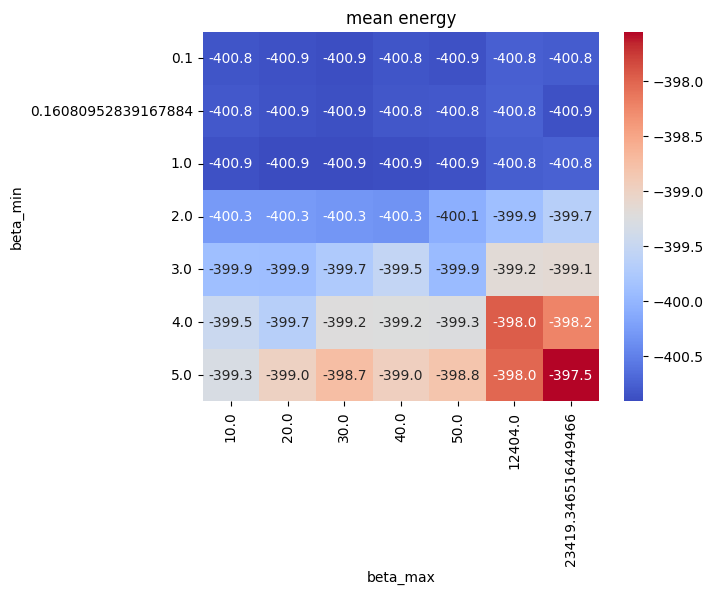

In [8]:
sns.heatmap(param_table, annot=True, fmt="1.1f", cmap="coolwarm")
plt.xlabel("beta_max")
plt.ylabel("beta_min")
plt.title("mean energy")
plt.show()

## 5. Result Analysis

Looking at the results, OpenJij's default parameters are good enough for this problem.

Let's examine another perspective. In OpenJij's algorithm, when a spin flip is rejected, no calculation is performed. When a spin flip occurs, the energy difference is calculated. Therefore, if the temperature is high (inverse temperature beta is low) for a long period, the number of spin flips increases, leading to increased computation time.

As a result, the computation time varies depending on the temperature settings. Let's visualize these results. OpenJij's computation time is measured in microseconds.

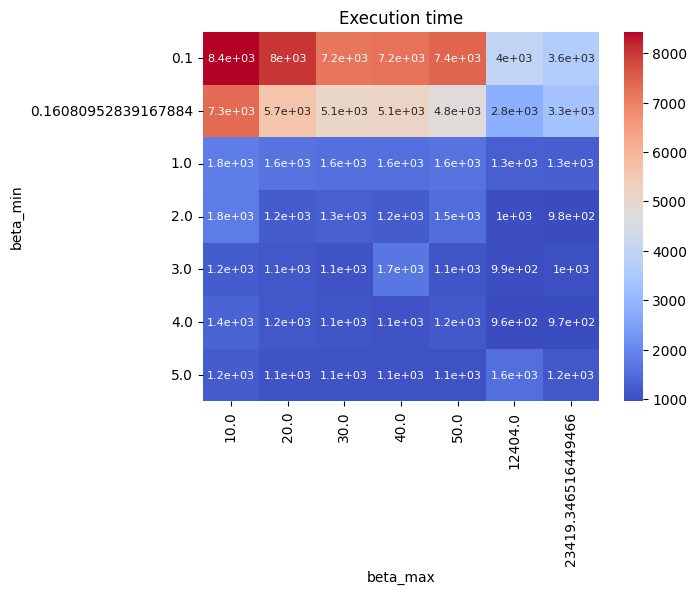

In [9]:
exec_table = run_table["parameter"].pivot(
    index="beta_min", columns="beta_max", values="exec_time"
)
sns.heatmap(exec_table, annot=True, cmap="coolwarm", annot_kws={"size": 8})
plt.xlabel("beta_max")
plt.ylabel("beta_min")
plt.title("Execution time")
plt.show()

# Analysis of OpenJij's Default Parameters

Unfortunately, from the perspective of computation time, OpenJij's default parameters do not appear to be optimal. The combination of beta_min=0.3 and beta_max=20~40 seems to be the best. This setting also yields good results in terms of computation time.

We hope that OpenJij's default parameters will be improved in the future.

As shown here, using minto makes it easy to tune the parameters of heuristic algorithms like OpenJij.

In [10]:
from openjij._version import __version__ as oj_version
print(f"OpenJij version: {oj_version}")

OpenJij version: 0.11.2
